#  IMDb Movie Review 
Sentiment Analysis Practice

Build a pipeline for sentiment analysis.

1. Tokenization
2. Normalization
3. Vectorization
4. Training  -- Multinomial NB
5. Evaluation

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 500)

In [2]:
train = pd.read_csv("train.csv")
train.sample(5)

,text,sentiment
20382,"...had I watched it in my teenage years. This movie was mildly entertaining. What I liked about Soul Survivors were the gothic atmosphere during the party scenes, and the constant flips between 'dream' and 'reality.<br /><br />Had there not been movies like 'The 6th Sense' and 'Don't Look Now' I would have been surprised by the ending.",neg
20469,"""Sleeping With the Enemy"" is a predictable, 'been there before' thriller that never seems to find any inspiration no matter how desperately cast and crew try. I can't believe a bunch of my friends talked me into seeing this at the movies some sixteen years ago.<br /><br />The complete lack of originality from the Ronald Bass screenplay (based upon the Nancy Price novel) does not help, nor does the stale direction of Joseph Ruben or the very average performance from Julia Roberts. The support...",neg
917,"This is one a most famous movies of the French sexual empowerment of the seventies, starring Gerard Depardieu and Patrick Dewaere in extremely sarcastic roles. It is also one of the many dark psychological dramas of the seventies/eighties, such as ""Serie Noire"", ""Buffet Froid"", ""Beau Pere"", all realized by Blier.<br /><br />However, I would like to correct the previous comment that was posted on the movie: the translated title in English is very far from the French version. It is true that b...",pos
9608,"Along with ""Brothers & Sisters"", ""Six Degrees"" was one of my favorite new dramas of fall 2006. <br /><br />Great cast all around, but really enjoyed the work of Campbell Scott (the come-back photog) and Hope Davis (recent widow of journalist killed in Iraq).<br /><br />Aside from the acting, the writing was fresh and the acting superb. The show was also shot in NYC, the real city, not the Warner Bros. or some other studio's backlot, adding a secondary layer or realism. <br /><br />I guess pe...",pos
12845,"Some nice scenery, but the story itself--in which a self-proclaimed Egyptologist (Lesley-Anne Down) visits Egypt and, in the course of doing Egyptologist things in the most un-Egyptologistic of ways (e.g., flash photography in the tombs, the handling of old parchment, etc.), uncovers a black market turf war and somehow (in the span of two days, no less!) becomes that war's jumpsuit-wearing epicenter--is more puzzling than any riddle the Sphinx ever posed. Down is simply awful as the visiting...",neg


In [3]:
test = pd.read_csv("test.csv")
test.sample(5)

,text,sentiment
8141,"This movie appears to have been overlooked by everyone. Someone should bring it out on VHS and DVD. It is an excellent film and far superior to the one with Brooke Shields, which was terrible. <br /><br />Jean Simmons deserves more credit than she is getting now days. It would be nice if all her films were offered on VHS or DVD. Jean Simmons was, and still is, a very good actress. She certainly was a beauty. In fact, she is still a beauty. She also has done extremely well on T.V. She is so m...",pos
21890,===========BIG SPOILER================================== This is a terrible movie with no likable characters. So many clichés and senseless scenes. It needs a good editor but then there might not be any movie left. Please save your two hours. The only de,neg
22049,"Odious Chuck Norris decided to put one final nail in the coffin<br /><br />containing his film career before going to the safe world of CBS<br /><br />Saturday night carnage with this hysterically bad supernatural<br /><br />actioner.<br /><br />For such a dumb movie this thing sure is plotty. Norris is Chicago<br /><br />cop Frank Shatter. First off, what kind of last name is ""Shatter""?<br /><br />Have you ever met any Shatters? Genforum.com has no listing for<br /><br />the last name Shatt...",neg
21578,"The other day I showed my boyfriend a great movie, Stand By Me, a movie I have shown to many people and they absolutely adored it, but for some odd reason he didn't like it. He lends me a movie called Backdraft and he tells me that he's shown it to many people and they loved it, instead I hated this movie. I don't think I've hated a movie so much in a while, how this movie has even a 6.6 rating is beyond me. I couldn't keep up with the five million stories here: Billy Baldwin becoming a fire...",neg
21543,"First off, I just watched a movie on SHOWTIME called Survival Island. It says it was a 2006 movie with Billy Zane and since I like him and couldn't sleep I thought I would check it out. Looked interesting. Watched it, and decided to look up on the IMDb who was this new face Juan Pablo Di Pace and OMG I could not believe it, this movie has been renamed THREE and will be a new movie?? It is playing again in 1 hr and 30 mins on Showtime Channel again and this date is May 28 and EDT or Florida t...",neg


In [4]:
print('train shape:', train.shape)
print('test  shape:', test.shape)

train shape: (25000, 2)
test  shape: (25000, 2)


In [5]:
# check data balance
train['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

## Preprocessing

### Tokenization and Normalization

1. Remove HTML tag (`<br />` in this case) from the review text
2. Remove punctuations (replace with whitespace)
3. Split review text into tokens
4. Remove tokens that are considered as "**stopwords**"
5. For the rest, do lemmatization

In [6]:
import nltk    # natural language tool kit
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yiting/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/yiting/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/yiting/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))  # replace punctuation with space ''
stopwords = nltk.corpus.stopwords.words('english')   #  stopwords from nltk
lemmatizer = nltk.WordNetLemmatizer()      # nltk 里已经训练好的词干提取器

In [8]:
stopwords[:10]    # 在任何文本里，都可能出现很多次，但对文本分类没有实际意义的单词，做分类时一般会去除这些词。 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
def preprocessing(line: str) -> str:
    """
    Take a text input and return the preprocessed string.
    i.e.: preprocessed tokens concatenated by whitespace
    """
    line = line.replace('<br />', '').translate(transtbl)    # 接受一个line 字符串，用replace的方法把html tag 给去掉，然后用translate 去掉标点符号。
    
    # list comprehension 
    tokens = [lemmatizer.lemmatize(t.lower(),'v')    # t 是一个token， lemmatizer.lemmatize 词根还原
              for t in nltk.word_tokenize(line)
              if t.lower() not in stopwords]
    
    return ' '.join(tokens)

In [10]:
# test 
test_str = "I bought several books yesterday<br /> and I really love them!"
preprocessing(test_str)

'buy several book yesterday really love'

In [11]:
from tqdm._tqdm_notebook import tqdm_notebook   #_tqdm -> tracking the progress of processing 
tqdm_notebook.pandas()

In [12]:
for df in train, test:
    df['text_prep'] = df['text'].progress_apply(preprocessing)
    # df['text_prep'] = df['text'].apply(preprocessing)
    # 本来应该用apply（preprocessing），这里用progress_apply（preprocessing）是因为之前引入了一个tqdm
    # tqdm 是一个progress bar，会显示进度 

In [13]:
assert train.shape == (25000, 3)
assert test.shape == (25000, 3)

In [14]:
train.sample(2)

,text,sentiment,text_prep
21460,Zodiac Killer. 1 out of 10. Worst acting ever. No really worst acting ever. David Hess (Last House on the Left . No the one from the seventies . Rent it it's really good) is the worst of the bunch (Pretty stiff competition but he is amazingly god-awful.) One would be hard pressed to find a home movie participant with such an awkward camera presence. The film actually screeches to a stunning painful halt when he is on the screen.<br /><br />Not that the film actually has any redeeming qualiti...,neg,zodiac killer 1 10 worst act ever really worst act ever david hess last house leave one seventies rent really good worst bunch pretty stiff competition amazingly god awful one would hard press find home movie participant awkward camera presence film actually screech stun painful halt screen film actually redeem qualities mr hess ruin film home movie camera look things pretty old one complete attach boom mike post production either come shovelware five year old computer could use could clean ...
5064,"This is a long lost horror gem starring Sydney Lassick (""Carrie"" and others) and Barbara Bach. It is sometimes difficult to locate a copy of this film but it's worth it. This film is creepy yet cheesy at the same time. It seems that 3 young newswomen (Karen, Vicky, and Jennifer) travel to the small city of Solvang, California to cover a festival when a mix-up occurs involving their hotel room and they seek refuge at the home of Earnest Keller (Lassick) and his strange wife Virginia. Vickie s...",pos,long lose horror gem star sydney lassick carrie others barbara bach sometimes difficult locate copy film worth film creepy yet cheesy time seem 3 young newswomen karen vicky jennifer travel small city solvang california cover festival mix occur involve hotel room seek refuge home earnest keller lassick strange wife virginia vickie stay behind feel ill 2 film story soon murder house cheesy way unknown force hide ventilation system decapitate close cover vent come crash tug basement soon karen...


### Build Vocabulary

Built the vocabulay instead of using `CountVectorizer` (N-gram) provided by sklearn. 

Using words in training data for building vocabulary.

In [15]:
# 把单词转化成向量： create 一个单词list，包含所有单词出现的次数 
all_words = [w for text in tqdm_notebook(train['text_prep']) 
             for w in text.split()]   # w is every word in every line 

In [16]:
# Use FreqDist to get count for each word
voca = nltk.FreqDist(all_words)  
print(voca)

<FreqDist with 65081 samples and 3022531 outcomes>


In [17]:
voca.most_common(10)

[('film', 48170),
 ('movie', 43912),
 ('one', 26747),
 ('make', 23538),
 ('like', 22335),
 ('see', 20773),
 ('get', 18108),
 ('time', 16143),
 ('good', 15124),
 ('character', 14153)]

In [18]:
# select the most common 10,000 words out of the total 60,000 words to avoid unnessasary words. 10,000 is subject to change
topwords = [word for word, _ in voca.most_common(10000)]   

### Vectorization / Featurization  with tf-idf 

In [19]:
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)

In [20]:
train_x, train_y = train['text_prep'], train['sentiment']
test_x, test_y = test['text_prep'], test['sentiment']

In [21]:
# Use topwords as vocabulary
tf_vec = TfidfVectorizer(vocabulary=topwords)

In [22]:
train_features = tf_vec.fit_transform(train_x)
test_features = tf_vec.transform(test_x)

In [23]:
assert train_features.shape == (25000, 10000)
assert test_features.shape == (25000, 10000)

In [24]:
train_features[0][:50].toarray()

array([[0.        , 0.12884974, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Training 

### Multinomial NB
suitable for classfication with discrete features

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [26]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
%%time

# Train Model
mnb_model.fit(train_features, train_y)

CPU times: user 63.5 ms, sys: 2.57 ms, total: 66 ms
Wall time: 68.6 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluation

In [28]:
from sklearn import metrics

In [29]:
# Predict on test set
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [30]:
print('Accuracy Score: %f' % metrics.accuracy_score(pred,test_y))

Accuracy Score: 0.833120


In [31]:
# Pass in as keyword arguments to make sure the order is correct
print(metrics.classification_report(y_true=test_y, y_pred=pred))

              precision    recall  f1-score   support

         neg       0.81      0.87      0.84     12500
         pos       0.86      0.80      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## Predict new text

In [32]:
def predict_new(prep_func,  # func for preprocessing
                vec,        # vectorizer
                model,      # model
                text):      # text
    
    prep_text = prep_func(text)
    features = vec.transform([prep_text])
    pred = model.predict(features)
    return pred[0]

In [33]:
from functools import partial

predict_new_p1 = partial(predict_new, preprocessing, tf_vec, mnb_model)

In [34]:
predict_new_p1('It looks nice')

'pos'

In [35]:
predict_new_p1('It looks horible')

'neg'

## Tunning hyper parameters

In [36]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [word for word, _ in voca.most_common(n)]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y), mnb_model, vec

# since the positive & negative class are 1:1 (balanced), accuracy_score is similar to the F-score. 
# Here use accuracy score as an indicator of how good the model is

In [37]:
train_with_n_topwords(500, tfidf=True)

(0.82496,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True,
                 vocabulary=['film', 'movie', 'one', 'make', 'like', 'see',
                             'get', 'time', 'good', 'character', 'go', 'watch',
                             'even', 'would', 'think', 'story', 'really', 'well',
                             'show', 'look', 'much', 'say', 'end', 'know',
                             'people', 'bad', 'also', 'first', 'great', 'give', ...]))

In [38]:
possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm_notebook(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])

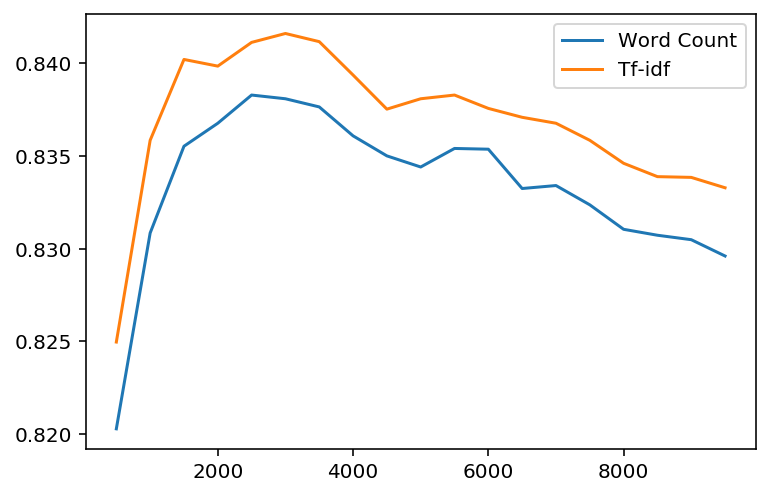

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()
plt.show()

Tf-idf is definitely better than CountVectorizer alone! The best size of words is around 3000.

## Save model

In [40]:
_, model, vec = train_with_n_topwords(3000, tfidf=True)

In [41]:
import pickle

with open('tf_vec.pkl', 'wb') as fp:
    pickle.dump(vec, fp)
    
with open('mnb_model.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [ ]:
!ls
# !dir